# __Project Description__

The following is an analysis of a toy dataset provided as part of a data science skills assessment.  The dataset contains 5 feature variables and 3 target variables which may or may not have been generated from the feature set.  The task is to describe the dataset and create and assess prediction models for the target variables.  

In [1]:
%matplotlib inline
import importlib
from IPython.display import display, HTML, Image
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression, LassoCV
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm, datasets
from sklearn import cross_validation, metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.svm import SVC, SVR
from sklearn.feature_selection import RFE, RFECV
from sklearn.base import clone
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from itertools import product
import pymc
from pymc.Matplot import plot as mcplot
import warnings
import pdb

warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '{0:4f}'.format(x))

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

#display(HTML(data="""
#<style>
#    div#notebook-container { width: 1850px; }
#</style>
#"""))

/Users/mgerstein/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_hists(df, measure_columns, min_max_pctiles, func, ncols=4, fontsize=12, figsize=(20,20)):
    if int(len(measure_columns) / ncols) != len(measure_columns) / float(ncols):
        nrows = int(len(measure_columns) / ncols) + 1
    else:
        nrows = int(len(measure_columns) / ncols)

    places = list(product(range(nrows), range(ncols)))
    idx = 0

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,)
    fig.set_size_inches(figsize)

    for i, col in enumerate(measure_columns):
        min_pctile = min_max_pctiles[col][0]
        max_pctile = min_max_pctiles[col][1]
 
        if nrows == 1 and ncols == 1:
            my_ax = ax
        elif nrows == 1 or ncols == 1:
            my_ax = ax[idx]
        else:
            my_ax = ax[places[idx][0]][places[idx][1]]

        if func == 'log':
            sns.distplot(np.log(df[(np.log(df[col]+1) >= np.log(df[col]+1).quantile(min_pctile)) & \
                                   (np.log(df[col]+1) <= np.log(df[col]+1).quantile(max_pctile))][col]+1), kde=True, ax=my_ax)
        elif func == 'sqrt':
            sns.distplot(np.sqrt(df[(np.sqrt(df[col]) >= np.sqrt(df[col]).quantile(min_pctile)) & \
                                    (np.sqrt(df[col]) <= np.sqrt(df[col]).quantile(max_pctile))][col]+1), kde=True, ax=my_ax)
        else:
            sns.distplot(df[(df[col] >= df[col].quantile(min_pctile)) & (df[col] <= df[col].quantile(max_pctile))][col], kde=True, ax=my_ax)

        new_x_label = my_ax.get_xlabel()
        
        my_ax.set_xlabel(new_x_label, fontdict={'fontweight': 'bold', 'fontsize': fontsize})
        my_ax.set_xticklabels(my_ax.get_xticklabels(), fontdict={'fontweight': 'bold', 'fontsize': fontsize})
        my_ax.set_yticklabels(my_ax.get_yticklabels(), fontdict={'fontweight': 'bold', 'fontsize': fontsize})
        
        if func == 'log':
            if np.log(df[col]+1).quantile(max_pctile) >= 10:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
            else:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
        elif func == 'sqrt':
            if np.sqrt(df[col]).quantile(max_pctile) >= 10:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
            else:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
        else:
            if df[col].quantile(max_pctile) >= 10:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
            else:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
               
        #my_ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

        idx += 1

    plt.tight_layout()
    plt.show()

In [3]:
def run_lm(X_train, X_test, y_train, y_test, mod):
    mod_c = clone(mod)
    mod_c.fit(X_train, y_train)
    y_pred_train = mod_c.predict(X_train)
    y_pred_test = mod_c.predict(X_test)

    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))

    sse = np.sum((y_train - y_pred_train)**2)
    sst = np.sum((y_train - np.mean(y_train))**2)
    r2 = 1 - sse / sst
    P = X_train.shape[1]
    N = X_train.shape[0]
    adj_r2 = r2 - (1 - r2) * (P / (N - P - 1))
    mse = sse / (N - P - 1)
    msm = (sst - sse) / P
    f_stat = msm / mse
    dfn = P
    dfd = N - P - 1
    p_value_f_stat = 1.0 - stats.f.cdf(f_stat, dfn, dfd)
    X_tstat = X_train.copy()
    X_tstat['const'] = 1
    X_tstat = X_tstat[['const', ] + list(X_train.columns.values)]
    C = np.linalg.inv(np.dot(X_tstat.T, X_tstat))
    SE = np.diag(np.sqrt(mse * C))
    t_stats = np.absolute(np.insert(mod_c.coef_, 0, mod_c.intercept_) / SE)
    hps = 1.0 - stats.t(dfd).cdf(t_stats)
    p_values = hps * 2.0
    
    result = {
        'model': mod_c,
        'measure': '',
        'regression': '',
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mse': mse,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2': r2,
        'adj_r2': adj_r2,
        'coef': list(zip(X_tstat.columns, np.insert(mod_c.coef_, 0, mod_c.intercept_), t_stats, p_values)),
        'f_stat': f_stat,
        'p_value_f_stat': p_value_f_stat,
    }
    
    return result

In [4]:
def get_best_alpha(model, X, y):
    alphas = np.logspace(-4, -0.5, 30)

    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    clf = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False)    
    clf.fit(X, y)
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']
    
    return alphas[np.argmax(scores)]

In [5]:
def remove_pair_plot_diag(g):
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)

In [6]:
def keep_pair_plot_rows(g, rows_to_keep):
    prev_col = -1
    current_row = 0
    pdb.set_trace()
    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            if j < prev_col:
                prev_col = -1
                current_row = i

            if g.axes[current_row, 0].get_ylabel() not in rows_to_keep:
                g.axes[i, j].set_visible(False)

            prev_col = j

In [7]:
def get_custom_pair_plot(df, x_cols, y_cols):
    fig, ax = plt.subplots(nrows=len(y_cols), ncols=len(x_cols))
    fig.set_size_inches(15, 10)

    for i, y_col in enumerate(y_cols):
        for j, x_col in enumerate(x_cols):
            ax[i, j].scatter(df[x_col], df[y_col])
            ax[i, j].set_xticks(np.linspace(np.floor(df[x_col].min()), np.ceil(df[x_col].max()), 5))
            ax[i, j].set_yticks(np.linspace(np.floor(df[y_col].min()), np.ceil(df[y_col].max()), 5))
            ax[i, j].get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
            ax[i, j].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))

            if j == 0:
                ax[i, j].set_ylabel(y_col)

            if i == len(y_cols) - 1:
                ax[i, j].set_xlabel(x_col)

    plt.tight_layout()
    plt.show()

In [8]:
def print_results(scores, result):
    print('Cross Val Scores: {0}'.format('|'.join(['{0:0.6f}'.format(score) for score in scores])))
    print('RMSE: {0:0.6f}'.format(result['rmse_test']))
    print('Adj R2: {0:0.6f}'.format(result['adj_r2']))
    print('f-stat p-value: {0:0.6f}'.format(result['p_value_f_stat']))
    print(''.join(['Feature: {0}, coefficient: {1:0.6f}, p-value: {2:0.6f}\n'.format(coef[0], coef[1], coef[2]) for coef in result['coef']]))

In [9]:
df = pd.read_csv('/Users/mgerstein/shared/mag/portfolio/data_set_1.csv')

In [10]:
feature_x = ['x1', 'x2', 'x3', 'x5', 'x6']
target_y = ['ya', 'yb', 'yc']
random_state = 17

##  __Data Exploration__

The dataset contains 100,000 observations of 8 continuous variables.  There is no missing data, no obvious outliers or anomalous values, and values are both positive and negative for all variables except x1.  Five of the eight variables are feature variables while the remaining three variables are target variables.  There does not appear to be any correlation between the features except for x1 and x3 which shows positive correlation.  Targets ya and yb show positive correlation with several of the features.  However, yc does not correlate with any of the feature variables.  Instead, yc positively correlates with the other two target variables.

In [11]:
pctiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
df.describe(pctiles)

,x1,x2,x3,x5,x6,ya,yb,yc
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.011059,-3.005565,2.500593,0.999136,0.000647,3.827867,2.111854,0.000102
std,2.873568,2.000799,1.752906,1.002006,4.663860,18.438514,0.769306,0.031212
min,0.000015,-12.498524,-3.489212,0.000003,-13.885453,-64.021995,-0.523672,-0.543361
1%,0.098351,-7.685865,-1.252595,0.010275,-11.142116,-35.229149,0.250147,-0.098510
5%,0.504249,-6.285427,-0.334530,0.051406,-8.196938,-24.521433,0.678696,-0.035156
10%,1.009150,-5.565638,0.188644,0.106422,-6.158874,-18.808622,0.984236,-0.016873
25%,2.536309,-4.353844,1.189920,0.285629,-2.611943,-8.998020,1.580212,-0.002423
50%,5.022191,-3.002649,2.503764,0.690903,-0.000611,2.666992,2.231057,-0.000000
75%,7.486275,-1.649283,3.802236,1.386862,2.621841,15.579687,2.733318,0.002477


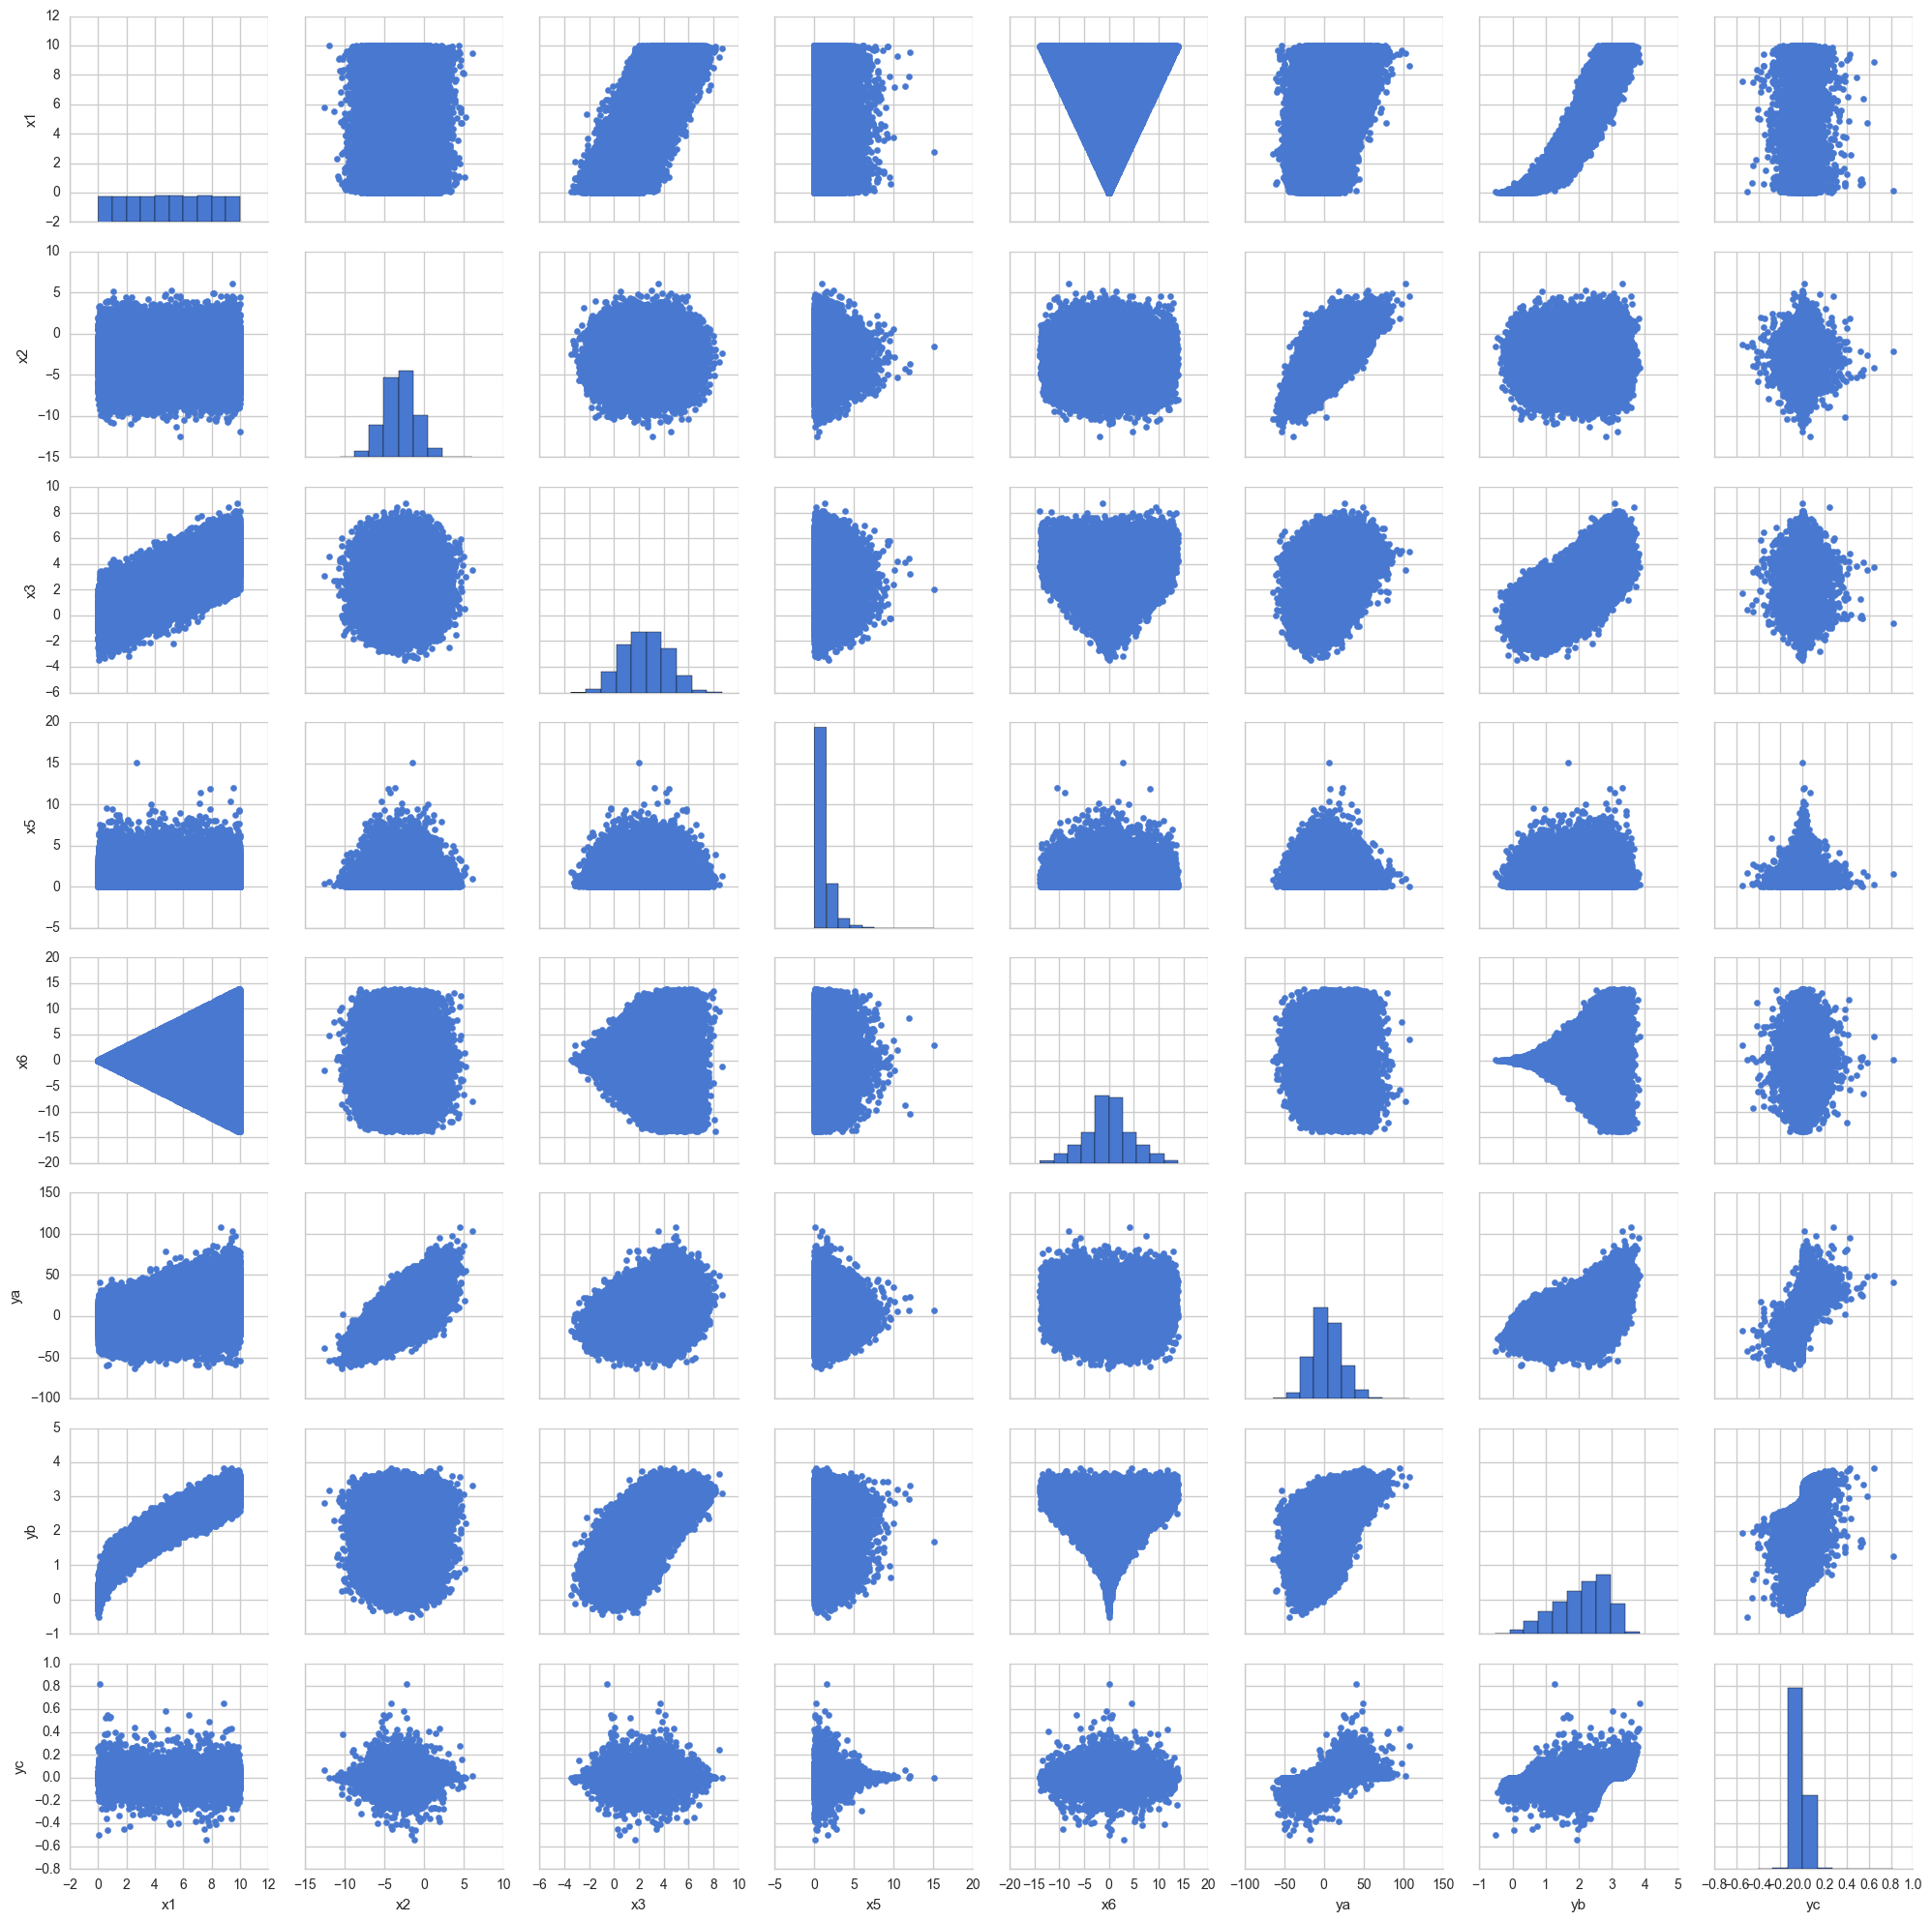

In [12]:
g = sns.PairGrid(df)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

The pair plots show the following relationships which should be considered when building predictive models for the targest.

* x1 and x3 have a linear relationship with a good amount of dispersion
* ya and x2 have a linear relationship
* ya and x1, x3 have relationships that indicate positive correlation and possible linearity
* yb and x1 have a non-linear relationship
* yb and x3 have a linear relationship
* yc and ya, yb have linear relationships

Correlation heatmaps can corrobate relationships between variables as well as indicate whether they are positive or negative.

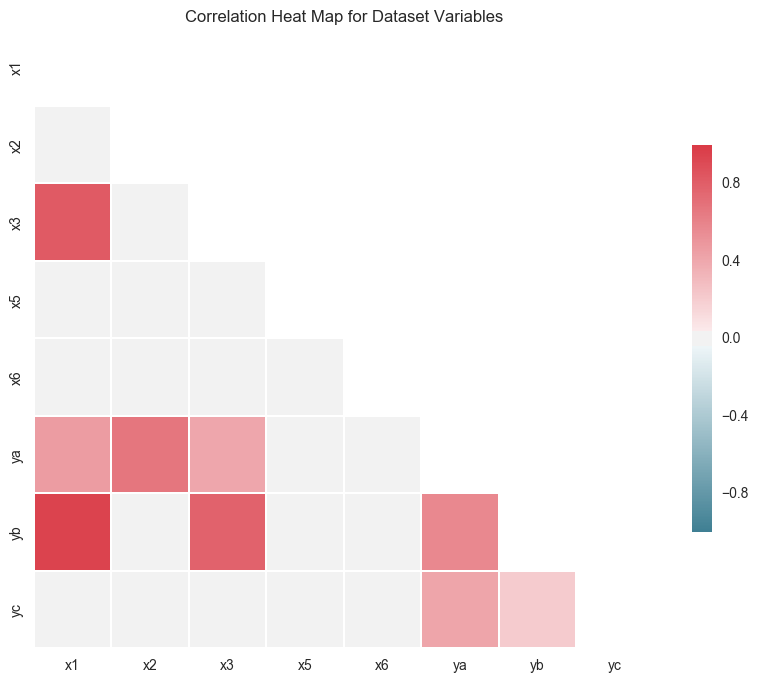

In [13]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Heat Map for Dataset Variables')
plt.show()

A closer look the distribution of each variable might help indicate up front trouble spots when it comes to model building.

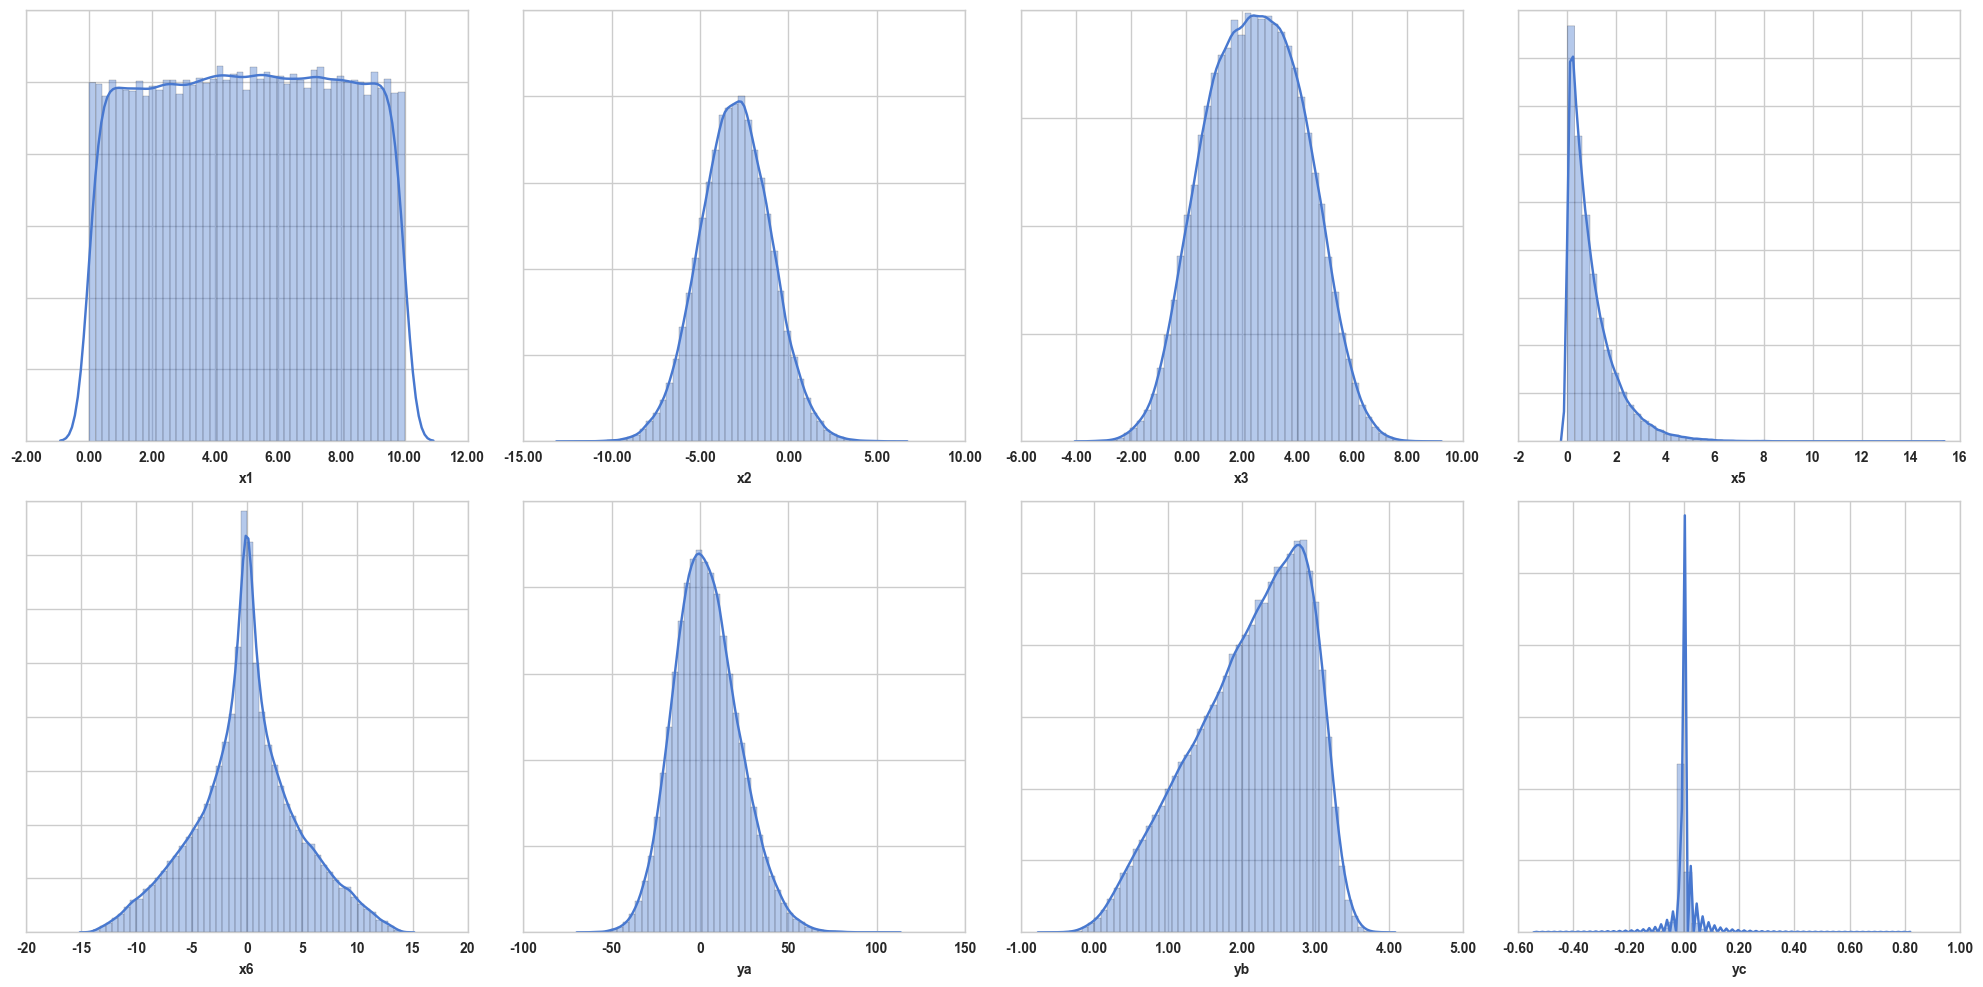

In [14]:
min_max_pctiles = {
    'x1': (0.00, 1.00), 
    'x2': (0.00, 1.00), 
    'x3': (0.00, 1.00), 
    'x5': (0.00, 1.00), 
    'x6': (0.00, 1.00), 
    'ya': (0.00, 1.00), 
    'yb': (0.00, 1.00), 
    'yc': (0.00, 1.00), 
}

get_hists(df, df.columns, min_max_pctiles, func='', ncols=4, fontsize=10, figsize=(20,10))

 The five feature variables appear to be generated from the following probability distributions.

*  x1 – Uniform distribution with a range of [0, 10]
*  x2 – Normal distribution with mu = 3 and sigma = 2
*  x3 – Beta distribution with a = 5.8 and b = 5.8
*  x5 – Exponential distribution with lambda = 1
*  x6 – Laplace distribution with mu = 0 and b = 3.5

The three target variables appear to be generated from the following distributions.  Although the best fit distribution for yc based on Kolmogorov–Smirnov test, the presence of material probability mass in both tails as shown in the histogram indicates that the data is best described by a Cauchy distribution.  Cauchy distributions can be difficult to model because of the commonness of outliers and undefined mean and variance.

*  ya – Lognormal distribution with mu = 3.83 and sigma = 18.44
*  yb – Right Truncated Inverse Weibull distribution with shape = 17, location = -8.5 and scale = 11
*  yc – Cauchy distribution with mu = 0 and gamma = 0.0023

In [15]:
dist_names = ['beta', 'cauchy', 'chi2', 'expon', 'gamma', 'laplace', 'lognorm', 'norm', 'pareto', 'powerlaw', 't', \
              'uniform', 'weibull_min', 'weibull_max']

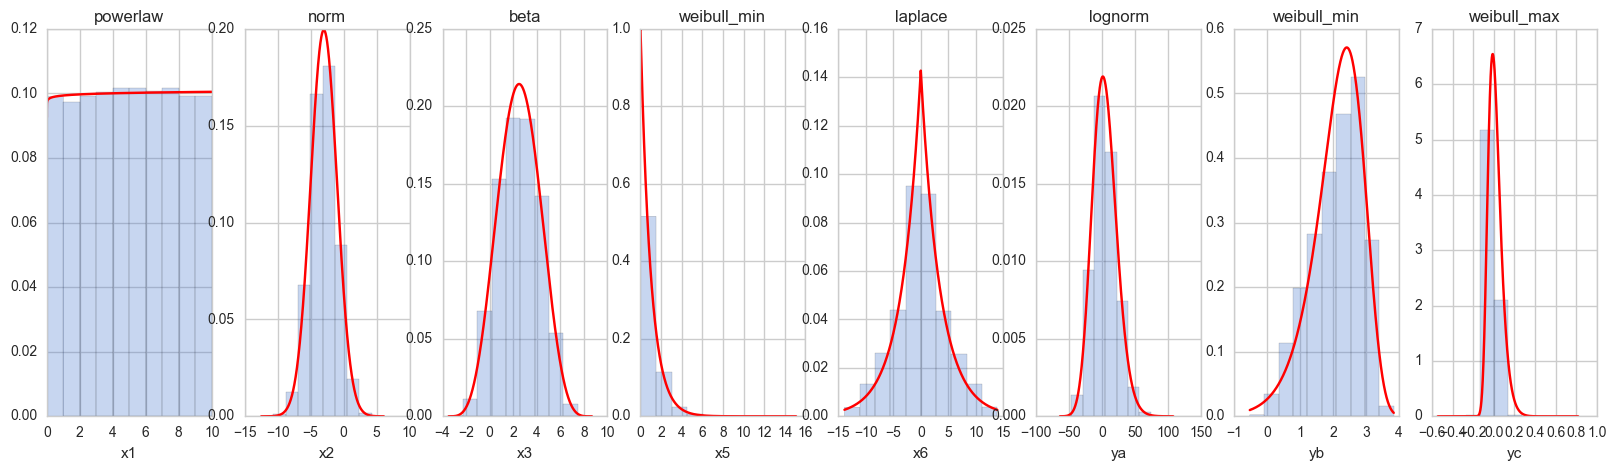

In [16]:
best_fits = []

for feature in feature_x + target_y:
    fit_data = df[feature]
    best_fit = {'dist_name': '', 'params': '', 'x': '', 'pdf_fitted': '', 'pvalue': 0, 'dvalue': 10**8, 'feature': feature}    
    
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        params = dist.fit(fit_data)
        x = np.linspace(fit_data.min(), fit_data.max(), len(fit_data))
        pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
        D, p = stats.kstest(fit_data, dist_name, args=params)

        if p >= best_fit['pvalue']:
            best_fit['dist_name'] = dist_name
            best_fit['params'] = params
            best_fit['x'] = x
            best_fit['pdf_fitted'] = pdf_fitted
            best_fit['pvalue'] = p
            best_fit['dvalue'] = D

    best_fits.append(best_fit)

fig, ax = plt.subplots(nrows=1, ncols=len(best_fits))
fig.set_size_inches(20, 5)    
    
for i, bf in enumerate(best_fits):
    my_ax = ax[i]
    my_ax.hist(df[bf['feature']], normed=True, alpha=0.30)
    my_ax.plot(bf['x'], bf['pdf_fitted'], 'r-')
    my_ax.set_xlabel(bf['feature'])
    my_ax.set_title(bf['dist_name'])
    
plt.show()

In [17]:
dist = getattr(stats, 'cauchy')
params = dist.fit(df.yc)
x = np.linspace(fit_data.min(), fit_data.max(), len(fit_data))
pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
D, p = stats.kstest(fit_data, dist_name, args=params)
print('mu = {0:.4f}, gamma = {1:.4f}'.format(params[0], params[1]))

mu = -0.0000, gamma = 0.0023


##  __Predictive Models__

To determine the type of model to be used for prediction, it is important to examine scatterplots of the feature variables against each of the target variables.  This type of plot helps identify the type of relationship between the two variables (i.e., linear, exponential, etc.).  In addition, a correlation matrix of the dataset can further corroborate what is seen visually in the plots.  For targets ya and yb, the scatterplots show several features with linear relationships as well as other features that are non-linear, but could be linear if transformed (i.e., log, square root, etc.).  Regularization (Lasso, Ridge, ElasticNet models) and stepwise regression are used to select important model features for a linear model to describe the targets.  Stability of the models is tested using cross fold validation to make sure variance in mean squared error is small.  



In [18]:
#Addition of feature variable transformations to the dataset
expanded_columns = []
df_expand = df.copy()

for col in feature_x:
    df_expand['sqrt_' + col] = np.sqrt(df_expand[col] + np.absolute(df_expand[col].min()) + .01)
    expanded_columns.append('sqrt_' + col)

for col in feature_x:
    df_expand['log_' + col] = np.log(df_expand[col] + np.absolute(df_expand[col].min()) + .01)
    expanded_columns.append('log_' + col)
    
for col in feature_x:
    df_expand['e_' + col] = np.exp(df_expand[col])
    expanded_columns.append('e_' + col)

for col in feature_x:
    for i in range(2, 4, 1):
        df_expand['poly_' + col + '_' + str(i)] = df_expand[col]**i
        expanded_columns.append('poly_' + col + '_' + str(i))

In [19]:
#Procedure to reularize or reduce feature set and then fit a model to that new feature set

regs = [('linear_regression', LinearRegression()), ('lasso', Lasso(fit_intercept=True, random_state=random_state)), \
        ('ridge', Ridge(fit_intercept=True, random_state=random_state)), ('elastic_net', ElasticNet(fit_intercept=True, random_state=random_state))]

lm_results = []

for name, linreg in regs:
    for j, y_col in enumerate(target_y):
        X = df_expand[[x for x in df_expand.columns if x not in target_y]]
        y = df_expand[y_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

        if name == 'linear_regression':
            estimator = linreg
            selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error') #Stepwise regression feature selector
            selection = selector.fit(X_train, y_train)

            new_columns = X.columns[np.argwhere(selection.ranking_ <= 1)].values.ravel()
        else:
            new_columns = X.columns

        X_best_features_train = X_train[new_columns]
        X_best_features_test = X_test[new_columns]

        if name != 'linear_regression':
            best_alpha = get_best_alpha(linreg, X_train, y_train)

            if name == 'lasso':
                result = run_lm(X_train, X_test, y_train, y_test, Lasso(fit_intercept=True, random_state=random_state, alpha=best_alpha))
            elif name == 'ridge':
                result = run_lm(X_train, X_test, y_train, y_test, Ridge(fit_intercept=True, random_state=random_state, alpha=best_alpha))
            elif name == 'elastic_net':
                result = run_lm(X_train, X_test, y_train, y_test, ElasticNet(fit_intercept=True, random_state=random_state, alpha=best_alpha))
        else:
            result = run_lm(X_best_features_train, X_best_features_test, y_train, y_test, linreg)

        result['regression'] = name
        result['measure'] = y_col

        lm_results.append(result)

As regularization complicates linear models, this technique is only considered if it provides for a material improvement in fit (greater than 5% reduction).  Root mean squared error is the metric used to measure goodness of fit in this situation.

In [20]:
#Select model for each target that has lowest root mean square error
best_results = []

for y_col in target_y:
    best_rmse = 10000000000
    best_result = None

    for result in lm_results:
        if result['measure'] == y_col:
            if result['rmse_test'] < best_rmse:
                if result['regression'] == 'linear_regression':
                    best_rmse = result['rmse_test']
                    best_result = result
                    best_results.append(best_result)
                elif result['rmse_test'] / best_rmse < 0.99:
                    best_rmse = result['rmse_test']
                    best_result = result                    
                    best_results.append(best_result)

In [21]:
#Display model results for best fit mode
rows_results = []

for result in best_results:
    for coef in result['coef']:
        rows_results.append({'regression': result['regression'], 'target': result['measure'], 'model_rmse': result['rmse_test'], 'feature': coef[0], 'value': coef[1], 'pvalue': coef[2]})

df_lm_results = pd.DataFrame(rows_results)
df_lm_results = df_lm_results[['regression', 'target', 'feature', 'value', 'pvalue']].set_index(['regression', 'target'])
df_lm_results

feature      value      pvalue
regression        target                                
linear_regression ya        const  66.774197    2.771024
                  ya           x1   4.029954   53.685148
                  ya           x2   8.422656    7.297113
                  ya           x3   1.847476    3.089158
                  ya      sqrt_x1  -5.949719   21.096372
                  ya      sqrt_x2 -23.717408    1.812721
                  ya      sqrt_x3  -8.156631    1.669989
                  ya       log_x2  15.623628    1.699833
                  ya       log_x3   4.471565    1.809450
                  yb        const  -0.014353    1.955801
                  yb      sqrt_x1   1.004183 1048.166440
                  yb       log_x2   0.001253    0.397994
                  yc        const  -0.000232    0.209716
                  yc       log_x2   0.000155    0.312887

Before removing all feature variables that have low p-values, it makes sense to visually confirm that the features do not have an obvious relationship to the target variable.  For ya, it looks like sqrt_x2 and log_x2 have a linear relationship.  However, inclusion of each separately and together into the model does not increase adjusted r-squared and rmse and still shows small p-values.  For yb, it looks like log_x1 has a polynomial relationship.  Adding the square of log_x1 to the model does not materially change the adjusted r-squared and rmse even though the coefficient shows a significant p-value.  For yc, the transformations show the same triangle shapes as the original features.

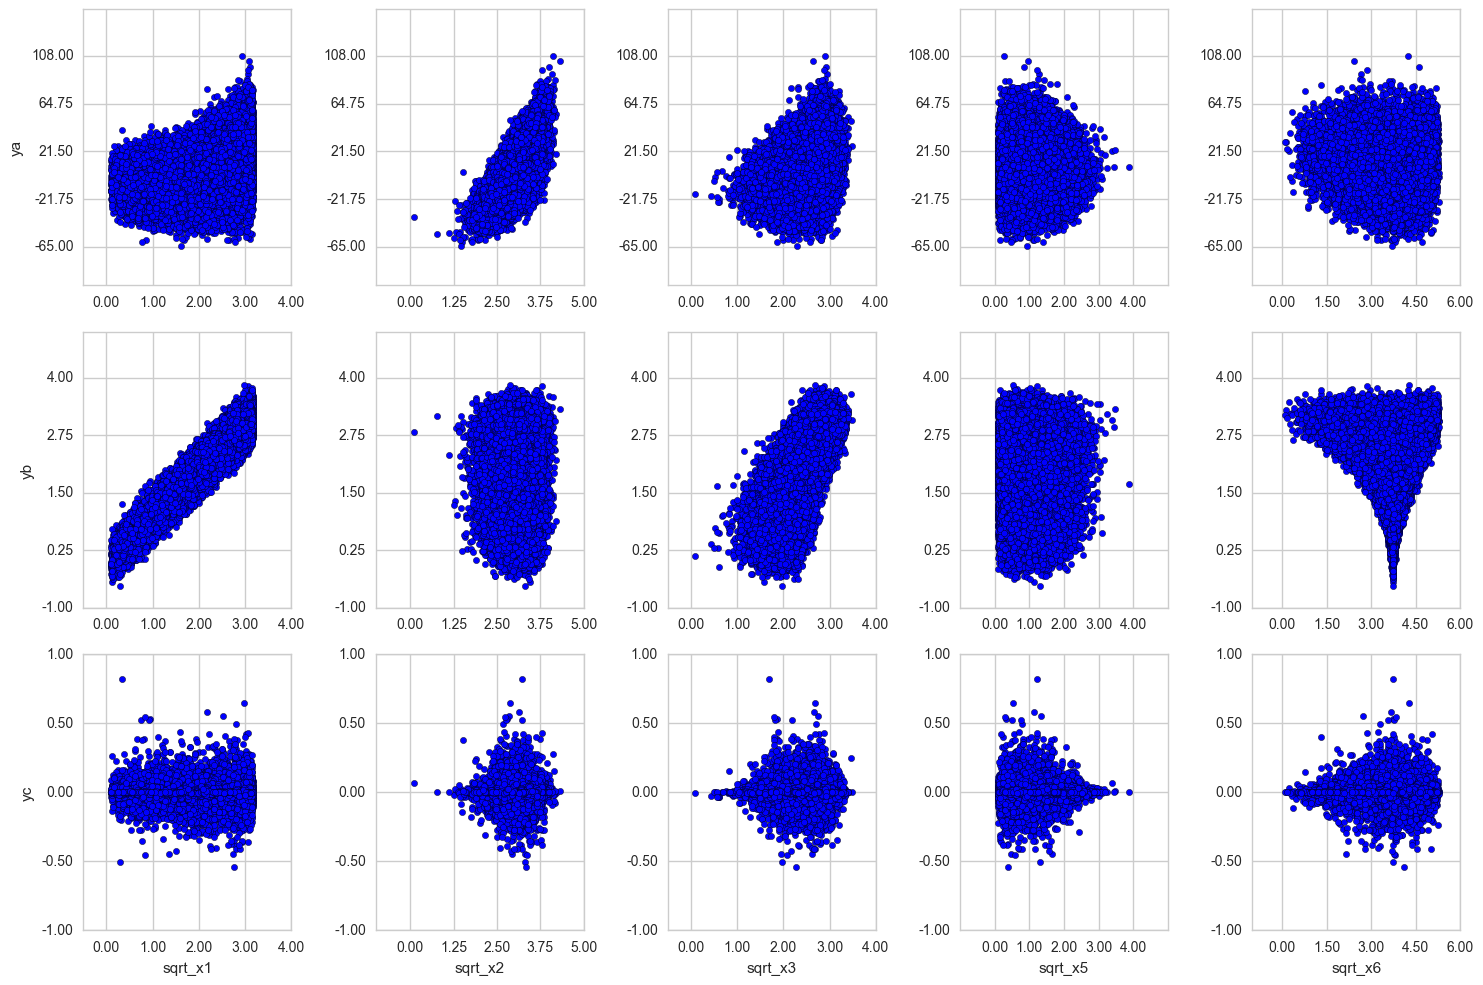

In [22]:
sqrts = [x for x in expanded_columns if 'sqrt_' in x]
get_custom_pair_plot(df_expand, sqrts, target_y)

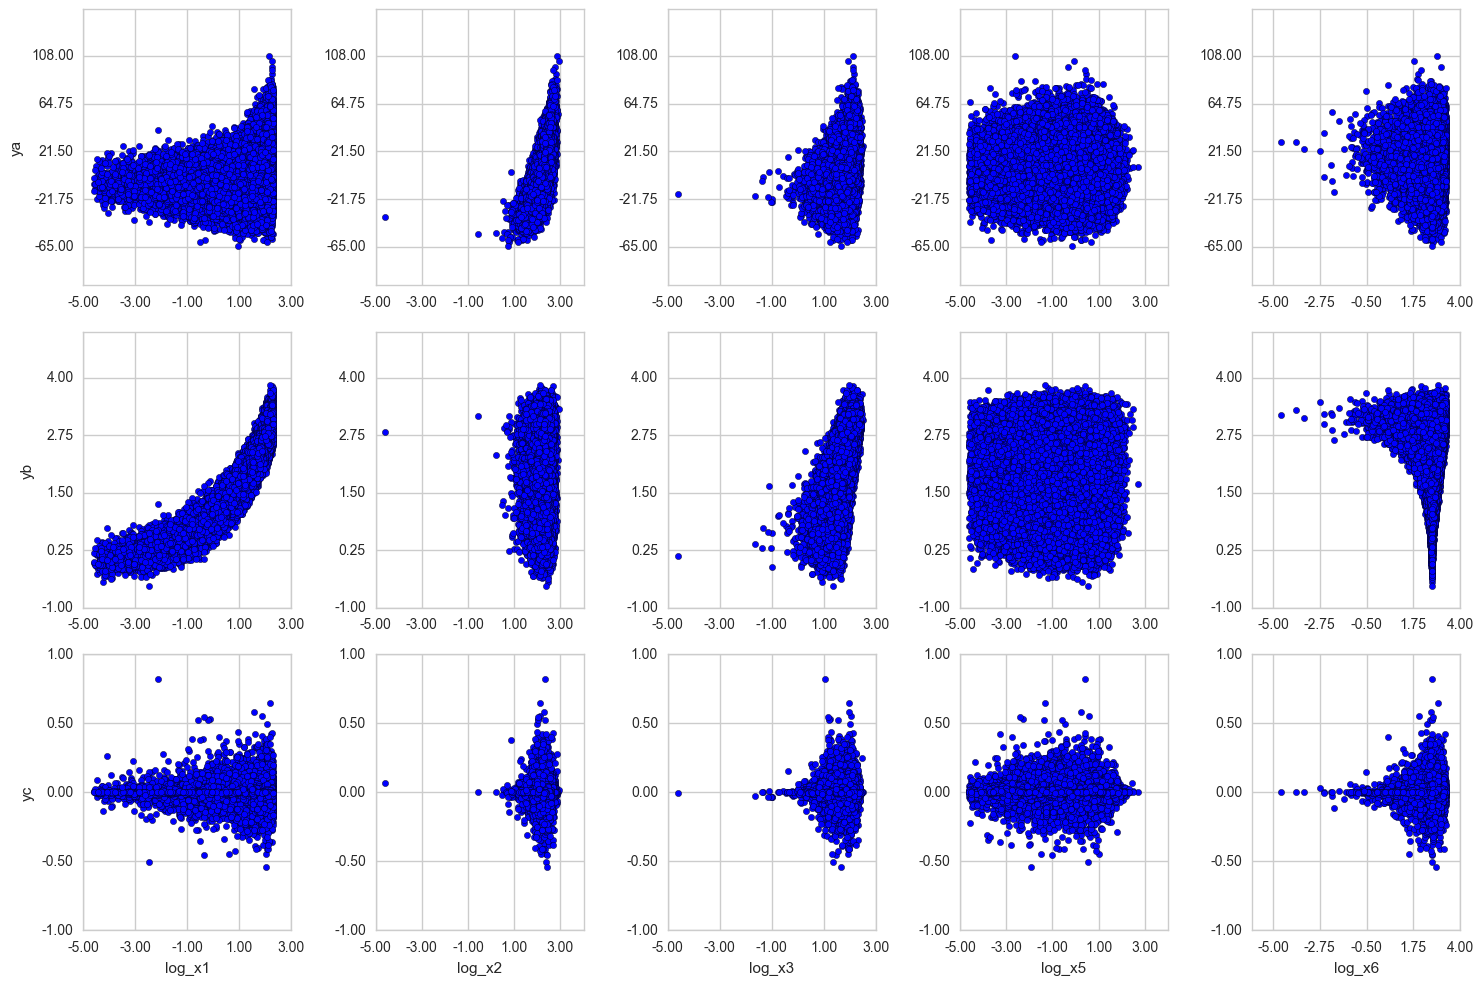

In [23]:
logs = [x for x in expanded_columns if 'log_' in x]
get_custom_pair_plot(df_expand, logs, target_y)

In [24]:
y_col = 'ya'
X_a = df_expand[['x1', 'x2', 'x3', 'sqrt_x1']]
y_a = df_expand[y_col]

mod = LinearRegression()
scores = cross_val_score(mod, X_a, y_a, cv=10, scoring='neg_mean_squared_error')
result_ya = run_lm(X_a, X_a, y_a, y_a, mod)

print_results(scores, result_ya)

Cross Val Scores: -107.273193|-109.568791|-108.851357|-108.729838|-109.516491|-108.193546|-109.625921|-112.015306|-108.910834|-108.125098
RMSE: 10.443719
Adj R2: 0.679166
f-stat p-value: 0.000000
Feature: const, coefficient: 12.668798, p-value: 60.858229
Feature: x1, coefficient: 4.032752, p-value: 66.946892
Feature: x2, coefficient: 6.233988, p-value: 377.658852
Feature: x3, coefficient: 0.948377, p-value: 28.726501
Feature: sqrt_x1, coefficient: -5.997112, p-value: 26.687245



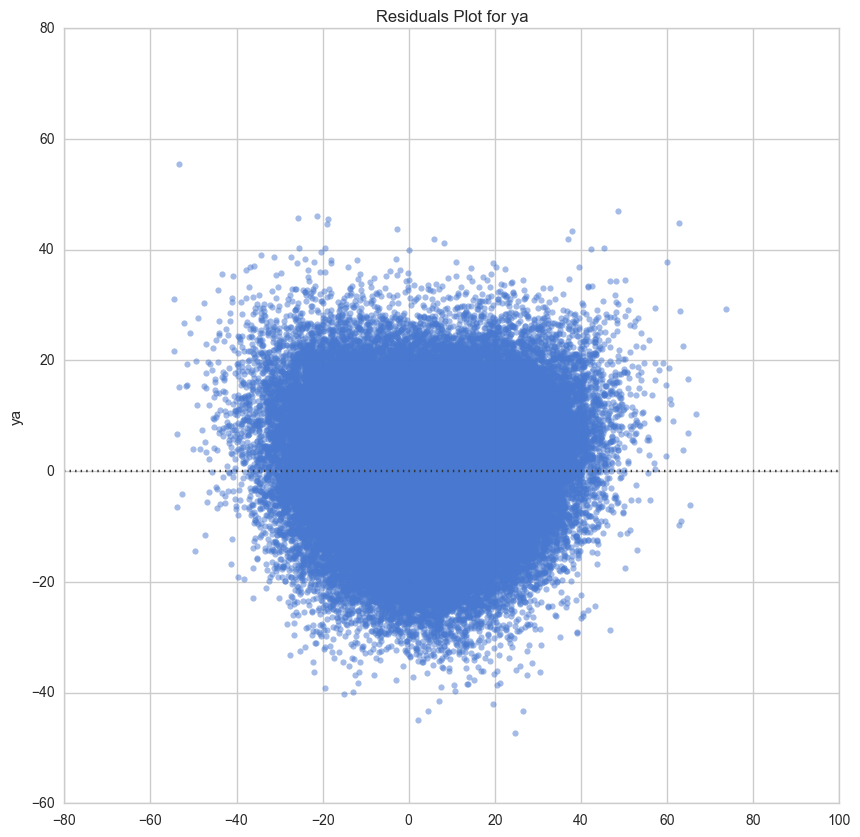

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)
sns.residplot(result_ya['model'].predict(X_a), 'ya', data=df, lowess=False, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
ax.set_title('Residuals Plot for ya')
plt.show()

ya = 12.669 + 4.033x1 + 6.234x2 + 0.948x3 - 5.997sqrt(x1)

The adjusted r-square of this model is 0.68 which indicates relatively good explanation of the variance of ya.  The p-value of the f-statistic is very small which means that the overall model is statistically significant with respect to the relationship between feature variables and the response variable.  The residual plot looks mostly uniform and random indicating a good fit although there might be influence of outliers or anomalous data.  However, the standard error of the model is 10.53.  This is equal to approximately 50% of the interquartile range meaning that there will be a lot of error in the prediction.  As a result, the predictions from the model are not usable. 

In [26]:
y_col = 'yb'
X_b = df_expand[['sqrt_x1']]
y_b = df_expand[y_col]

mod = LinearRegression()
scores = cross_val_score(mod, X_b, y_b, cv=10, scoring='neg_mean_squared_error')
result_yb = run_lm(X_b, X_b, y_b, y_b, mod)

print_results(scores, result_yb)

Cross Val Scores: -0.039375|-0.040039|-0.040453|-0.039999|-0.040338|-0.039882|-0.040069|-0.040789|-0.039990|-0.039516
RMSE: 0.200109
Adj R2: 0.932338
f-stat p-value: 0.000000
Feature: const, coefficient: -0.011111, p-value: 5.798793
Feature: sqrt_x1, coefficient: 1.003746, p-value: 1173.853194



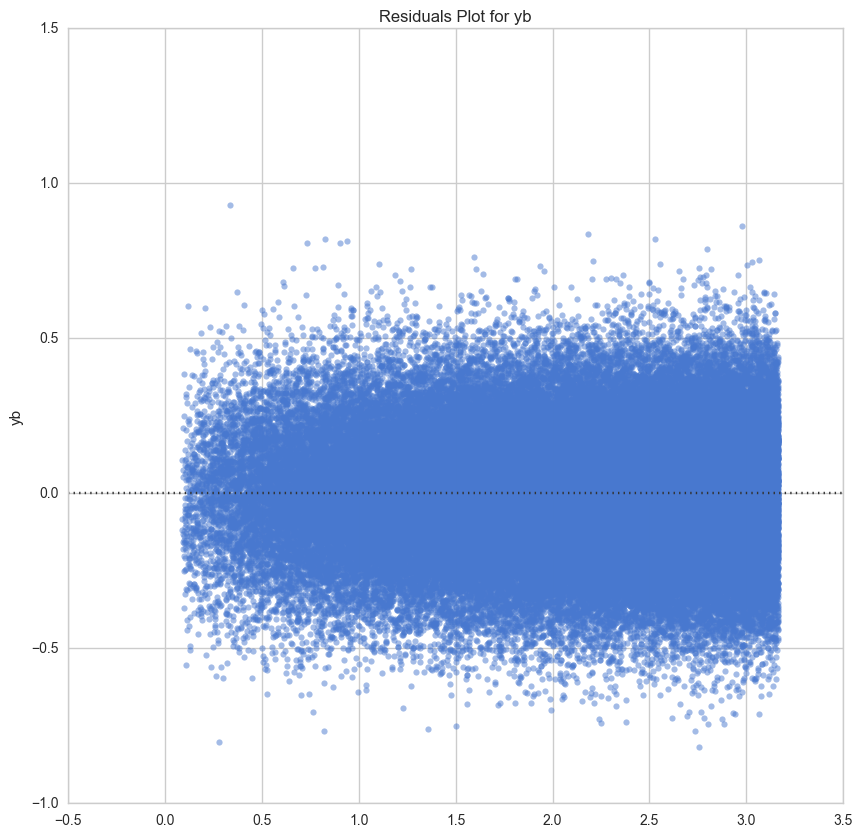

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)
sns.residplot(result_yb['model'].predict(X_b), 'yb', data=df, lowess=False, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
ax.set_title('Residuals Plot for yb')
plt.show()

yb = -0.011 + 1.00374sqrt(x1)

The adjusted r-square of this model is 0.93 which indicates almost a complete explanation of the variance of yb.  The p-value of the f-statistic is very small which means that the overall model is statistically significant with respect to the relationship between feature variable and the response variable.  The residual plot looks uniform and random indicating a good fit and no influence of outliers or anomalous data.  The standard error of the model is 0.20.  This value is relatively small compared to the range of values of yb.  As a result, predictions from this model can be relied on.

Upfront, making predictions of yc is going to be difficult because the data follows a Cauchy distribution which has large probability mass in fat tails making outliers likely.
After examining the scatterplots, it does not appear that any of the relationships with the original feature variables or transformed feature variables is linear.  Linear regression resulted in a model with r-squares less than 0.05 and an f-statistic that is not significant.

In [28]:
y_col = 'yc'
X_c = df_expand[['log_x2']]
y_c = df_expand[y_col]

mod = LinearRegression()
scores = cross_val_score(mod, X_c, y_c, cv=10, scoring='neg_mean_squared_error')
result_yc = run_lm(X_c, X_c, y_c, y_c, mod)

print_results(scores, result_yc)

Cross Val Scores: -0.000868|-0.000943|-0.000984|-0.001005|-0.001081|-0.000923|-0.000939|-0.001016|-0.001000|-0.000985
RMSE: 0.031212
Adj R2: -0.000010
f-stat p-value: 0.962894
Feature: const, coefficient: 0.000057, p-value: 0.058308
Feature: log_x2, coefficient: 0.000020, p-value: 0.046522



However, the scatterplots show that yc is correlated with both ya and yb with linear relationships.  It might be possible to use the output of the models for ya and yb as inputs to a linear regression to predict yc.  An initial linear model resulted in poor small r-squareds and insignificant f-statistics.

In [29]:
y_col = 'yc'
X_c = pd.DataFrame({'ya': result_ya['model'].predict(X_a), 'yb': result_yb['model'].predict(X_b)}, columns=['ya', 'yb'])
y_c = df_expand[y_col]

mod = LinearRegression()
scores = cross_val_score(mod, X_c, y_c, cv=10, scoring='neg_mean_squared_error')
result_yc = run_lm(X_c, X_c, y_c, y_c, mod)

print_results(scores, result_yc)

Cross Val Scores: -0.000868|-0.000943|-0.000984|-0.001005|-0.001081|-0.000923|-0.000939|-0.001016|-0.001000|-0.000985
RMSE: 0.031212
Adj R2: -0.000014
f-stat p-value: 0.736144
Feature: const, coefficient: -0.000095, p-value: 0.283217
Feature: ya, coefficient: 0.000001, p-value: 0.130690
Feature: yb, coefficient: 0.000091, p-value: 0.577899



Linear regression assumes that residuals are distributed N~(0,1).  However, this assumption does not hold for yc because it has a Cauchy distribution.  Bayesian inference might provide a better model for yc by allowing for the modeling of errors that follow a Cauchy distribution.  Unfortunately, this does not result in a usuable model based on r-squared and RMSE.  yc appears to be completely drawn from a Cauchy distribution making it very difficult to model without significant error because of the frequency of outliers.

In [30]:
beta0 = pymc.Normal('beta0', 0, 0.0001)
beta1 = pymc.Normal('beta1', 0, 0.0001)
beta2 = pymc.Normal('beta2', 0, 0.0001)

xa = pymc.Normal('ya', mu=df.ya.mean(), tau=(1.00 / (df.ya.std()**2)) , value=result_ya['model'].predict(X_a), observed=True)
xb = pymc.Normal('yb', mu=df.yb.mean(), tau=(1.00 / (df.yb.std()**2)), value=result_yb['model'].predict(X_b), observed=True)

err = pymc.Cauchy('err', alpha=0, beta=0.0023)

@pymc.deterministic(plot=False)
def linear_regress(xa=xa, xb=xb, beta0=beta0, beta1=beta1, beta2=beta2):
    return beta0 + xa*beta1 + xb*beta2

yc = pymc.Cauchy('yc', alpha=linear_regress, beta=(1.00 / err**2), value=df_expand.yc, observed=True)
#yc = pymc.Normal('yc', mu=linear_regress, tau=(1.00 / err**2), value=df_expand.yc, observed=True)

model = pymc.Model([xa, xb, yc, err, beta0, beta1, beta2])
mcmc = pymc.MCMC(model)
mcmc.sample(iter=100000, burn=50000)

 [-----------------100%-----------------] 100000 of 100000 complete in 1108.7 sec

Plotting beta0
Plotting err
Plotting beta2
Plotting beta1


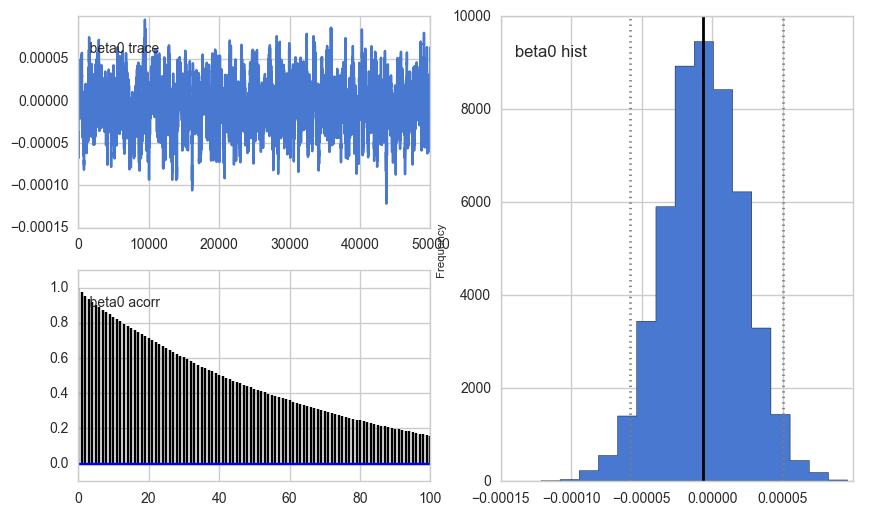

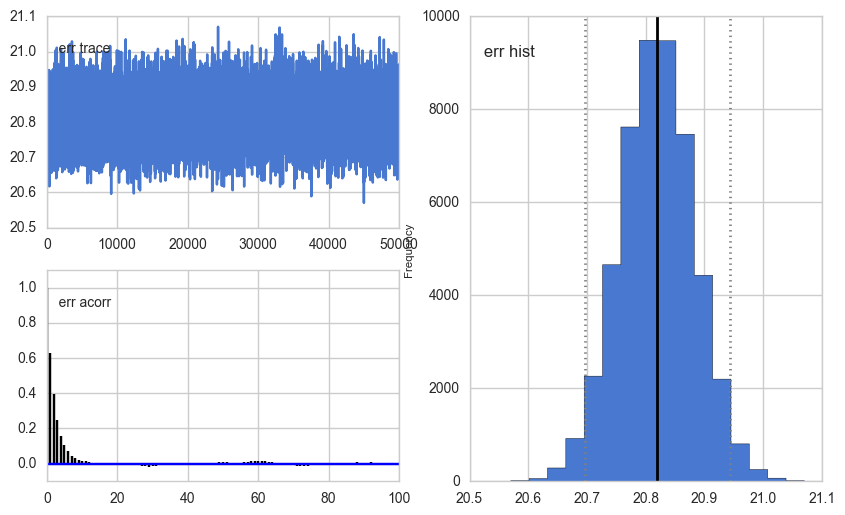

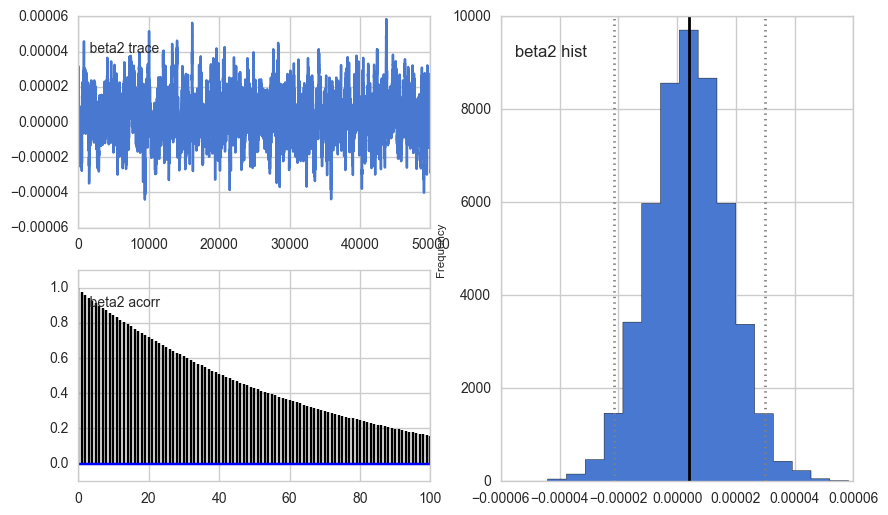

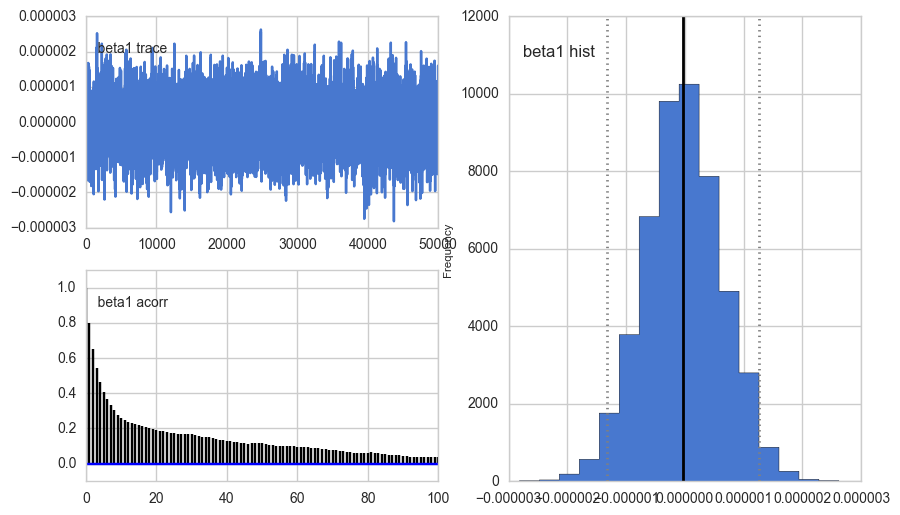

In [31]:
mcplot(mcmc)

In [32]:
beta0_samples = mcmc.trace('beta0')[:]
beta1_samples = mcmc.trace('beta1')[:]
beta2_samples = mcmc.trace('beta2')[:]
print('{0:0.6f}, {1:0.6f}, {2:0.6f}'.format(beta0_samples.mean(), beta1_samples.mean(), beta2_samples.mean()))

-0.000006, -0.000000, 0.000004


In [33]:
print('beta0_samples 95th CI [{0:0.6f}, {1:0.6f}]'.format(stats.mstats.mquantiles(beta0_samples, [0.025, 0.975], axis=0)[0], stats.mstats.mquantiles(beta0_samples, [0.025, 0.975], axis=0)[1]))
print('beta1_samples 95th CI [{0:0.6f}, {1:0.6f}]'.format(stats.mstats.mquantiles(beta1_samples, [0.025, 0.975], axis=0)[0], stats.mstats.mquantiles(beta1_samples, [0.025, 0.975], axis=0)[1]))
print('beta2_samples 95th CI [{0:0.6f}, {1:0.6f}]'.format(stats.mstats.mquantiles(beta2_samples, [0.025, 0.975], axis=0)[0], stats.mstats.mquantiles(beta2_samples, [0.025, 0.975], axis=0)[1]))

beta0_samples 95th CI [-0.000061, 0.000047]
beta1_samples 95th CI [-0.000001, 0.000001]
beta2_samples 95th CI [-0.000021, 0.000030]


In [34]:
y_c_pred = beta0_samples.mean() + beta1_samples.mean() * X_c.ya + beta2_samples.mean() * X_c.yb

In [35]:
rmse_yc = np.sqrt(metrics.mean_squared_error(df_expand.yc, y_c_pred))
r2_yc = metrics.r2_score(df_expand.yc, y_c_pred)
print('RMSE: {0:0.6f}, R2: {1:0.6f}'.format(rmse_yc, r2_yc))

RMSE: 0.031212, R2: -0.000010


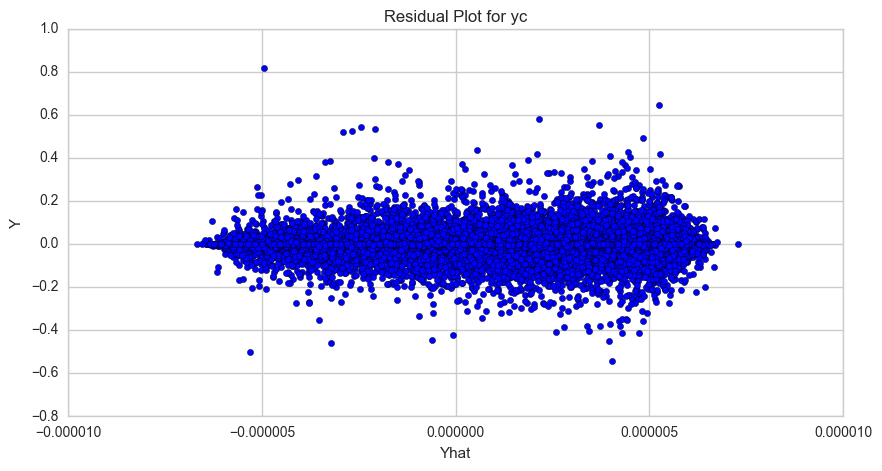

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

ax.scatter(y_c_pred, df_expand.yc)
ax.set_xlim(-0.00001, 0.00001)
ax.set_xlabel('Yhat')
ax.set_ylabel('Y')
ax.set_title('Residual Plot for yc')
plt.show()